# 1. IMPORTS

In [23]:
# misc libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn classes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Distribution matching class
from sklearn.mixture import GaussianMixture

# 2. Dataset generation

## Constant and functions

In [24]:
ROOT_DIR= '/mnt/d/NOTES-ARCHIVE/PROJECT3/Code/Dataset_distilled'
LABELS= ["Benign","Bruteforce","Dos/DDos","Mirai","Recon","Spoofing","Web-based"]

In [25]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()

In [26]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return 1

## Loading and dropping column with single-value

In [27]:
df = pd.read_csv(f'{ROOT_DIR}/distilled_feature_dataset.csv')

In [28]:
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)
df.drop(single_value_cols,axis=1, inplace=True) 

## Dataset stat

In [29]:
# Display the original class distribution
print(df['class'].value_counts(ascending=True))

class
Bruteforce     7544
Benign        10000
Dos/DDos      10000
Recon         10000
Mirai         10000
Web-based     10000
Spoofing      10000
Name: count, dtype: int64


<Axes: >

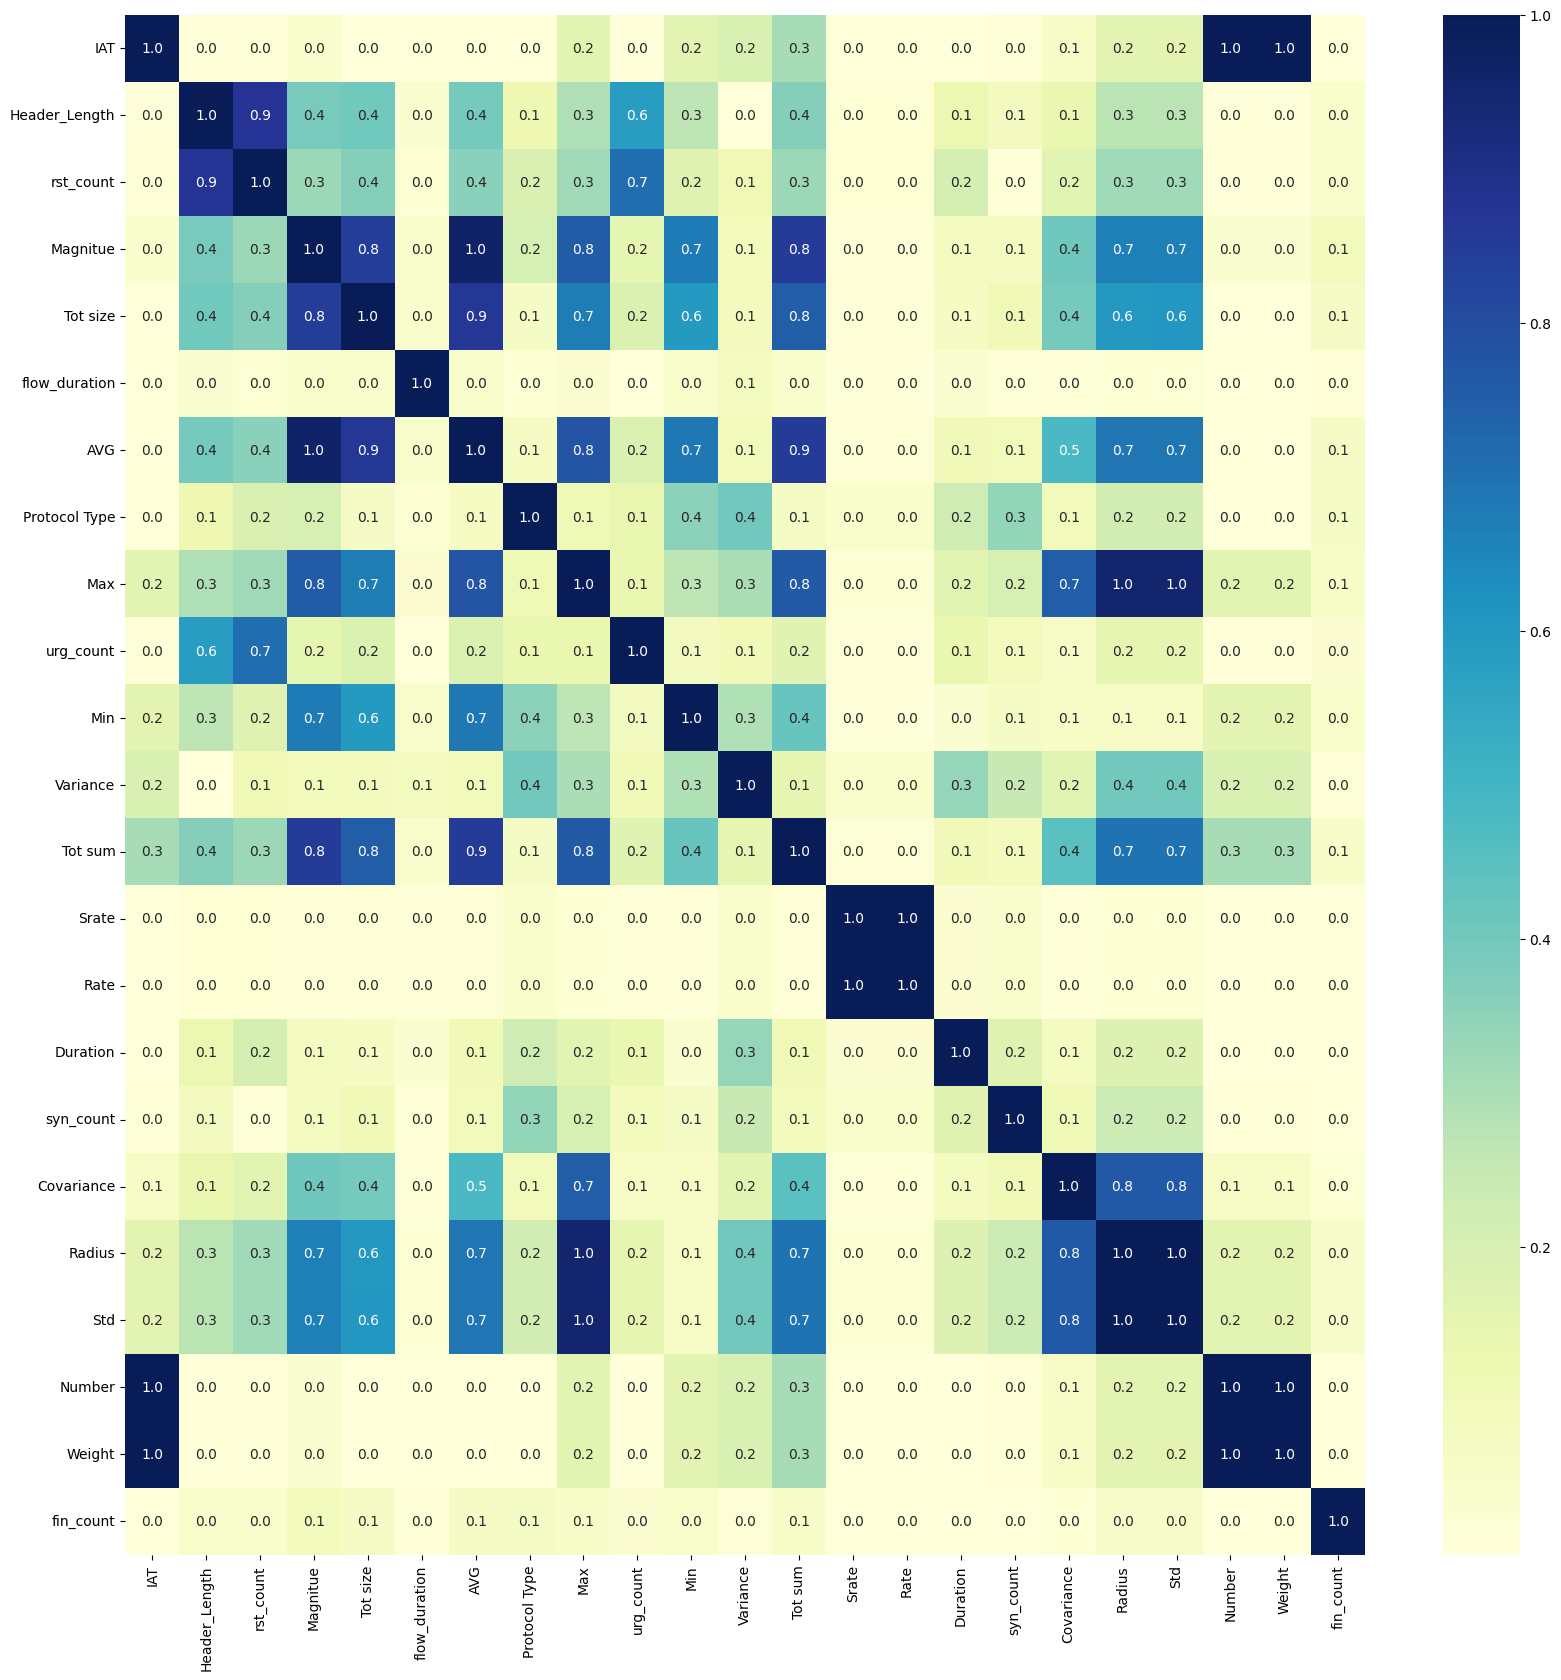

In [30]:
# Display the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")

In [31]:
# Display number of columns
num_columns = df.shape[1]

# Output the number of columns
print(f"The number of columns in the DataFrame is: {num_columns}")

The number of columns in the DataFrame is: 24


## Split into training and testing set

In [32]:
sub_df = df  

# remove nan, inf, -inf value
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)] 

In [33]:
X = sub_df.iloc[:,:-1]
Y = sub_df.iloc[:,-1]

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))
print(X_train.shape,X_test.shape)

(54035, 23) (13509, 23)


## Data scaling

In [35]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Distribution matching with Gaussian Mixture

In [36]:

synthetic_data = []
synthetic_labels = []

for label in LABELS:
    # Filter data for each class
    X_class = X_train[Y_train == label]

    # Fit a GMM for each class separately
    gmm = GaussianMixture(n_components=3,reg_covar=1e-4)
    gmm.fit(X_class)
    
    # Generate synthetic data for this class
    X_synthetic_class = gmm.sample(n_samples=1000)[0]  # Generate 100 samples for this class
    y_synthetic_class = np.full((1000,), label)  # Assign the same class label

    synthetic_data.append(X_synthetic_class)
    synthetic_labels.append(y_synthetic_class)

# Combine the synthetic data and labels
X_synthetic = np.vstack(synthetic_data)
y_synthetic = np.hstack(synthetic_labels)

In [37]:
# Count the number of occurrences of each label
unique_labels, label_counts = np.unique(y_synthetic, return_counts=True)

# Display the counts for each label
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

Label Benign: 1000 samples
Label Bruteforce: 1000 samples
Label Dos/DDos: 1000 samples
Label Mirai: 1000 samples
Label Recon: 1000 samples
Label Spoofing: 1000 samples
Label Web-based: 1000 samples


In [38]:
print(X_synthetic.shape,y_synthetic.shape)

(7000, 23) (7000,)


## Scaling synthetic data

In [39]:
scaler = StandardScaler()
X_synthetic_scaled = scaler.fit_transform(X_synthetic)

# 3. Random Forest

## Random forest classifier

In [40]:
RF_clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
RF_clf.fit(X_synthetic_scaled, y_synthetic)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

## Random-forest benchmark

              precision    recall  f1-score   support

      Benign       0.54      0.63      0.58      1963
  Bruteforce       0.28      0.30      0.29      1490
    Dos/DDos       0.97      0.99      0.98      2088
       Mirai       0.99      0.99      0.99      1985
       Recon       0.78      0.31      0.45      1935
    Spoofing       0.90      0.28      0.43      2028
   Web-based       0.39      0.79      0.53      2020

    accuracy                           0.63     13509
   macro avg       0.69      0.61      0.61     13509
weighted avg       0.71      0.63      0.62     13509



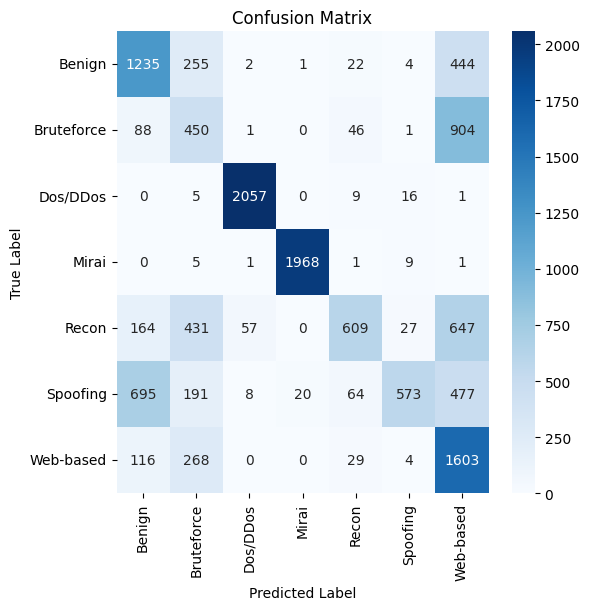

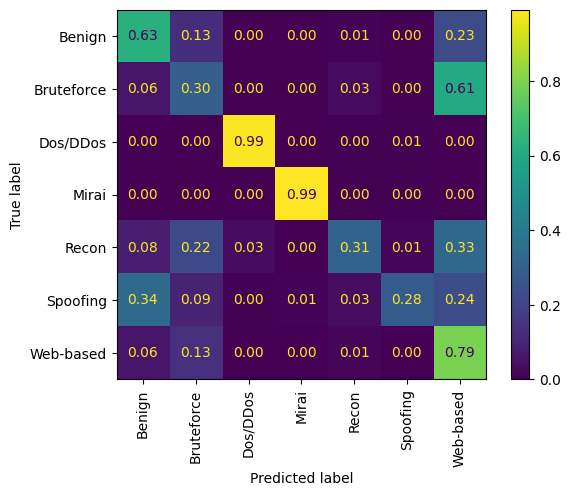

In [41]:
RF_clf_Y_pred = RF_clf.predict(X_test)
print(classification_report(Y_test, RF_clf_Y_pred))
plot_confusion_matrix(Y_test,RF_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, RF_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 5. SGDC classifier

In [42]:
SGDC_clf = SGDClassifier(eta0=1.0,penalty='elasticnet',learning_rate='adaptive',alpha=0.0001,max_iter=10000, tol=1e-9,n_jobs=-1)
SGDC_clf.fit(X_synthetic_scaled, y_synthetic)

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('sgdclassifier',
                 SGDClassifier(max_iter=10000, n_jobs=-2, tol=1e-07))])

## SGDC benchmark

              precision    recall  f1-score   support

      Benign       0.32      0.34      0.33      1963
  Bruteforce       0.29      0.39      0.33      1490
    Dos/DDos       0.86      0.94      0.89      2088
       Mirai       0.95      0.99      0.97      1985
       Recon       0.65      0.30      0.41      1935
    Spoofing       0.67      0.43      0.52      2028
   Web-based       0.31      0.45      0.37      2020

    accuracy                           0.56     13509
   macro avg       0.58      0.55      0.55     13509
weighted avg       0.59      0.56      0.56     13509



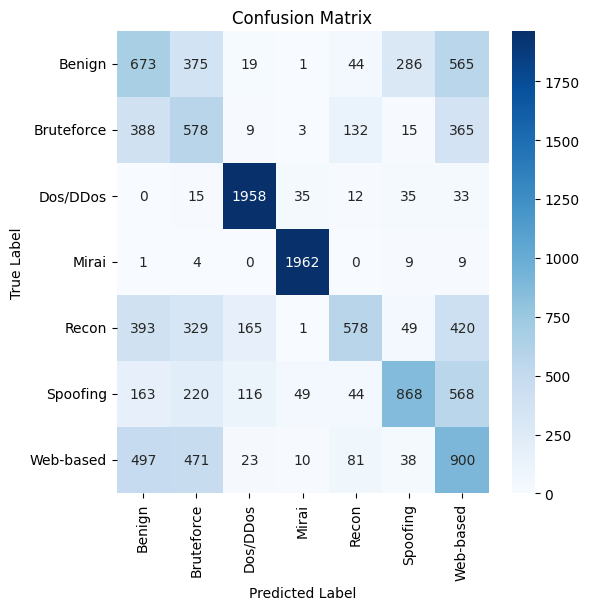

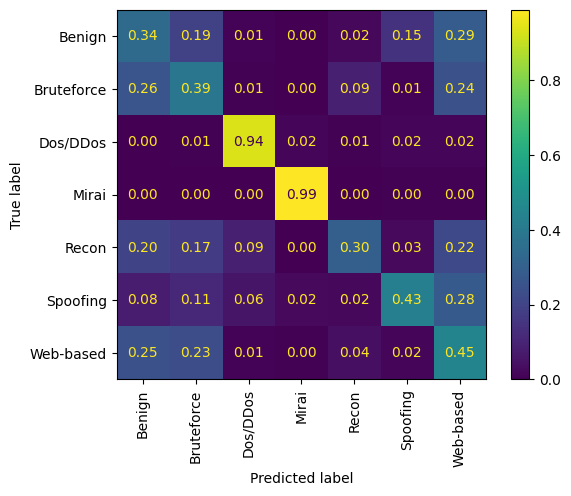

In [43]:
SGDC_clf_Y_pred = SGDC_clf.predict(X_test)
print(classification_report(Y_test, SGDC_clf_Y_pred))
plot_confusion_matrix(Y_test,SGDC_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, SGDC_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 6. MLP

In [44]:
mlp = MLPClassifier(
  hidden_layer_sizes=(128,),
  activation='relu',
  alpha=0.0001,
  solver='adam',
  learning_rate='constant',
  learning_rate_init=0.0002,
  max_iter=10000,
  random_state=42
)
mlp.fit(X_synthetic_scaled, y_synthetic)

MLPClassifier(hidden_layer_sizes=(128,), learning_rate_init=0.0002,
              max_iter=10000, random_state=42)

              precision    recall  f1-score   support

      Benign       0.61      0.59      0.60      1963
  Bruteforce       0.32      0.38      0.35      1490
    Dos/DDos       0.99      0.99      0.99      2088
       Mirai       0.99      0.99      0.99      1985
       Recon       0.81      0.33      0.47      1935
    Spoofing       0.88      0.43      0.57      2028
   Web-based       0.42      0.82      0.55      2020

    accuracy                           0.66     13509
   macro avg       0.72      0.65      0.65     13509
weighted avg       0.73      0.66      0.66     13509



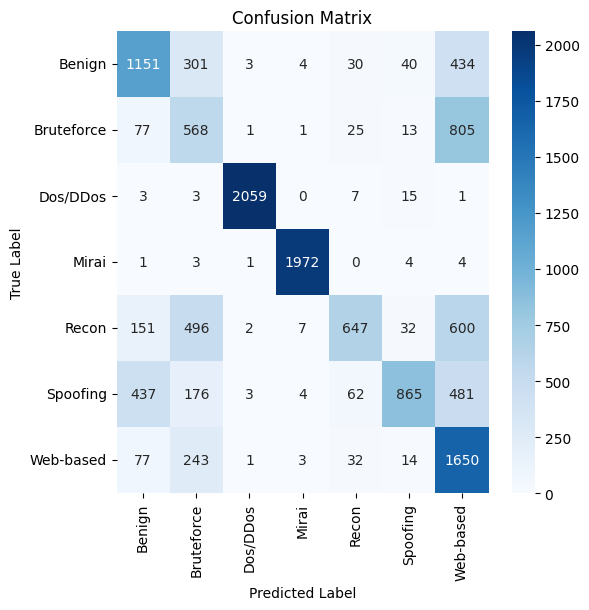

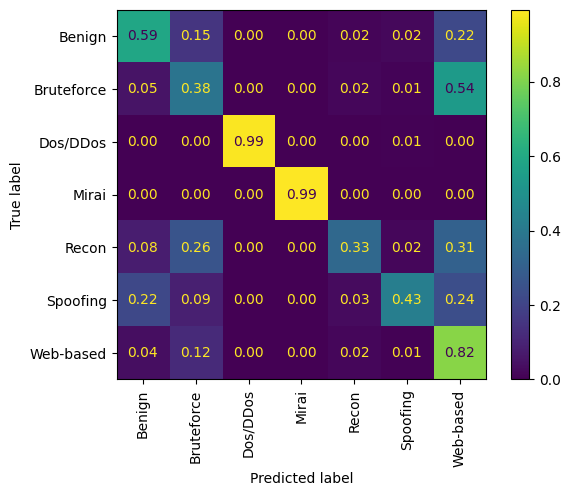

In [45]:
MLP_clf_Y_pred = mlp.predict(X_test)
print(classification_report(Y_test, MLP_clf_Y_pred))
plot_confusion_matrix(Y_test,MLP_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, MLP_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')